In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import homcloud.interface as hc

Porespy не работает с последним numpy, а для homcloud нужен последний

In [22]:
# image = porespy.generators.blobs([50,50],0.5)
# plt.imshow(image, cmap = 'gray')
# None

In [23]:
I = pd.read_csv('datasets/mnist_train.csv', header = 0)
answers = np.array(I['label'])
I = np.array(I)[:,1:]/255
images = I.reshape((-1,28,28))
image = images[0]

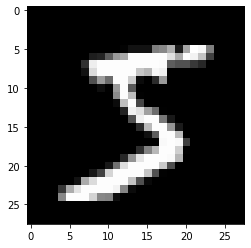

In [24]:
plt.imshow(image, cmap = 'gray')

array([[0.07843137, 0.2745098 , 0.07843137],
       [0.39215686, 1.        , 0.50980392],
       [0.07843137, 0.78431373, 0.19607843]])

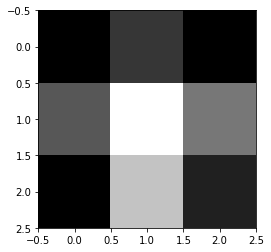

In [25]:
image = np.array([[20,70,20],
                   [100,255,130],
                   [20,200,50]])/255
plt.imshow(image, cmap = 'gray')
image

In [26]:
# image = 1 - image
# plt.imshow(image, cmap = 'gray')

In [27]:
pd_hc_pore = hc.PDList.from_bitmap_levelset(image)
print("Births component:",pd_hc_pore.dth_diagram(0).births)
print("Deaths component:",pd_hc_pore.dth_diagram(0).deaths)

print("Births holes:",pd_hc_pore.dth_diagram(1).births)
print("Deaths holes:",pd_hc_pore.dth_diagram(1).deaths)


pd_hc_pore.dth_diagram(0).essential_births, pd_hc_pore.dth_diagram(0).essential_birth_positions

# pd_hc_pore.dth_diagram(0).histogram().plot(colorbar={"type": "log"},
# title="Title string")
# plt.show()

Births component: [0.07843137 0.07843137 0.19607843]
Deaths component: [0.2745098  0.39215686 0.50980392]
Births holes: [0.78431373]
Deaths holes: [1.]


(array([0.07843137]), [[0, 0]])

Добавлять ли последнюю выжившую компоненту?

In [28]:
births = np.concatenate((pd_hc_pore.dth_diagram(0).essential_births, pd_hc_pore.dth_diagram(0).births))
deaths = np.concatenate((pd_hc_pore.dth_diagram(0).deaths, np.array([1.0])))
deaths

array([0.2745098 , 0.39215686, 0.50980392, 1.        ])

Построить кривую Бетти по персистентной диаграмме

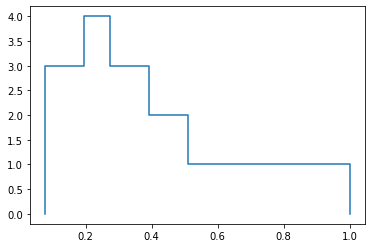

In [29]:
from numpy import cumsum
def betti_plot(births, deaths):
    b = np.array([births])
    b = b.T
    b = np.concatenate((b, np.array([np.ones(len(b))]).T), axis=1)
    
    d = np.array([deaths])
    d = d.T
    d = np.concatenate((d, np.array([-np.ones(len(b))]).T), axis=1)
    
    sort = np.concatenate((b,d))
    sort = sort[sort[:, 0].argsort()]
    
    times = sort[:, 0]
    counts = cumsum(sort[:,1])
    
    x = np.array([])
    y = np.array([])
    
    counter = 0
    i = 0
    while i < len(times):
        while (i + 1 < len(times) and times[i + 1] == times[i]):
            i += 1
        x = np.append(x, times[i])
        x = np.append(x, times[i])
        y = np.append(y, counter)
        y = np.append(y, counts[i])
        counter = counts[i]
        i += 1
        
    return x, y
x, y = betti_plot(births, deaths)
plt.plot(x,y)

In [30]:
x = x[1::2]
y= y[1::2]
x,y

(array([0.07843137, 0.19607843, 0.2745098 , 0.39215686, 0.50980392,
        1.        ]),
 array([3., 4., 3., 2., 1., 0.]))

In [31]:
def betti(births, deaths, step):
    b = np.array([births])
    b = b.T
    b = np.concatenate((b, np.array([np.ones(len(b))]).T), axis=1)
    
    d = np.array([deaths])
    d = d.T
    d = np.concatenate((d, np.array([-np.ones(len(d))]).T), axis=1)
    
    sort = np.concatenate((b,d))
    sort = sort[sort[:, 0].argsort()]
    
    times = sort[:, 0]
    counts = cumsum(sort[:,1])
    
    res_times = np.arange(step, 1, step)
    res_counts = np.arange(step, 1, step)
    cur_res = 0
    cur_ind = 0
    while cur_res < len(res_times):
        while cur_ind < len(times) and times[cur_ind] <= res_times[cur_res]:
            cur_ind += 1
        if cur_ind == 0:
            res_counts[cur_res] = 0
        else:
            res_counts[cur_res] = counts[cur_ind - 1]
        cur_res += 1
    
    return res_counts

In [32]:
res_counts = betti(births, deaths, 0.1)

In [33]:
res_counts

array([3., 4., 3., 2., 2., 1., 1., 1., 1.])

In [34]:
def diag_dist(births, deaths):
    return np.abs(births - deaths)/ np.sqrt(2)

In [35]:
def dist(births, deaths):
    res = []
    for (x,y) in zip(births, deaths):
        dists = np.sqrt((births - x)**2 + (deaths - y)**2)
        first_dist = np.partition(dists,min(1, len(dists) - 1))[min(1, len(dists) - 1)]
        second_dist = np.partition(dists,min(2, len(dists) - 1))[min(2, len(dists) - 1)]
        third_dist = np.partition(dists,min(3, len(dists) - 1))[min(3, len(dists) - 1)]
        res.append([first_dist,second_dist,third_dist])
    return np.array(res).T

In [36]:
def get_diagram(image, typ):
    pd_hc_pore = hc.PDList.from_bitmap_levelset(image)
    births = np.concatenate((pd_hc_pore.dth_diagram(typ).essential_births, pd_hc_pore.dth_diagram(typ).births))
    if len(births) == 1:
        deaths = np.array([1.0])
    elif typ == 1:
        deaths = pd_hc_pore.dth_diagram(typ).deaths;
    else:
        deaths = np.concatenate((np.array([1.0]), pd_hc_pore.dth_diagram(typ).deaths))
    return np.vstack((births, deaths, diag_dist(births,deaths), dist(births, deaths)))

In [37]:
get_diagram(image,0)

array([[0.07843137, 0.07843137, 0.07843137, 0.19607843],
       [1.        , 0.2745098 , 0.39215686, 0.50980392],
       [0.65164743, 0.13864839, 0.22183742, 0.22183742],
       [0.50411608, 0.11764706, 0.11764706, 0.16637807],
       [0.60784314, 0.26306682, 0.16637807, 0.26306682],
       [0.7254902 , 0.7254902 , 0.60784314, 0.50411608]])

# Сохраняем датасеты

## Датасет диаграмм персистентности

In [38]:
X_train, X_test = images[:50000], images[50000:]
y_train, y_test = answers[:50000], answers[50000:]
print(X_train.shape, X_test.shape)

(50000, 28, 28) (10000, 28, 28)


In [39]:
X_diag_train = []
i = 0
for im in X_train:
    X_diag_train.append(get_diagram(im, 0))
    print(i)
    i+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070


3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779


KeyboardInterrupt: 

In [40]:
print(X_diag_train[2])

[[0.         0.01960784]
 [1.         0.10980392]
 [0.70710678 0.06377826]
 [0.890412   0.890412  ]
 [0.890412   0.890412  ]
 [0.890412   0.890412  ]]


In [41]:
X_diag_test = []
i = 0
for im in X_test:
    X_diag_test.append(get_diagram(im, 0))
    print(i)
    i+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103


3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773


5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504


KeyboardInterrupt: 

In [42]:
import pickle
with open('X_train_brightness_diagrams', 'wb') as config_dictionary_file:
    pickle.dump(X_diag_train, config_dictionary_file)
with open('X_test_brightness_diagrams', 'wb') as config_dictionary_file:
    pickle.dump(X_diag_test, config_dictionary_file)

## Датасет кривых Бетти

In [43]:
def get_betti(image,typ,step):
    # angle is step of direction, typ 1(holes) or 0(components), step in timings of betti curve

    pd_hc_pore = hc.PDList.from_bitmap_levelset(image)
    births = np.concatenate((pd_hc_pore.dth_diagram(typ).essential_births, pd_hc_pore.dth_diagram(typ).births))
    deaths = np.concatenate((pd_hc_pore.dth_diagram(typ).deaths, np.array([1.0])))
    return betti(births, deaths, step)


In [44]:
X_betti_train = []
i = 0
for im in X_train:
    X_betti_train.append(get_betti(im, 0, 0.1))
    print(i)
    i+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085


KeyboardInterrupt: 

In [ ]:
X_betti_test = []
i = 0
for im in X_test:
    X_betti_test.append(get_betti(im, 0, 0.1))
    print(i)
    i+=1

In [ ]:
import pickle
with open('X_train_brightness_betti', 'wb') as config_dictionary_file:
    pickle.dump(X_betti_train, config_dictionary_file)
with open('X_test_brightness_betti', 'wb') as config_dictionary_file:
    pickle.dump(X_betti_test, config_dictionary_file)

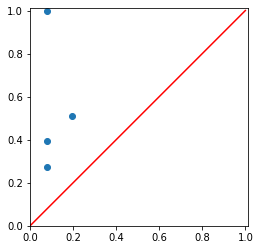

In [71]:
pd_hc_pore = hc.PDList.from_bitmap_levelset(image)
births = np.concatenate((pd_hc_pore.dth_diagram(0).essential_births, pd_hc_pore.dth_diagram(0).births))
if len(births) == 1:
    deaths = np.array([1.0])
elif 0 == 1:
    deaths = pd_hc_pore.dth_diagram(0).deaths;
else:
    deaths = np.concatenate((np.array([1.0]), pd_hc_pore.dth_diagram(0).deaths))
    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(births,deaths)
plt.xlim([0,1.01])
plt.ylim([0,1.01])
plt.autoscale(False)
plt.plot([0,1], c='red')
ax.set_aspect('equal', adjustable='box')
plt.savefig('diagram.png',bbox_inches='tight', pad_inches=0)

In [68]:
image

array([[0.07843137, 0.2745098 , 0.07843137],
       [0.39215686, 1.        , 0.50980392],
       [0.07843137, 0.78431373, 0.19607843]])

In [70]:
from PIL import Image
im = Image.fromarray(image*255).convert('RGB')
im.save(f"image.jpeg")

In [51]:
births, deaths

(array([0.07843137, 0.07843137, 0.07843137, 0.19607843]),
 array([1.        , 0.2745098 , 0.39215686, 0.50980392]))